In [53]:
#Understanding necessary Astropy tools
from astropy import units as u 
from astropy import constants as cst 
from astropy.coordinates import SkyCoord
from astropy.table import QTable, Table

import numpy as np 

#Example of use: Units and Constants 
g_force  = (cst.G * cst.M_sun * cst.M_earth) / (u.au)**2
print(f'Gravitational force beetwen Sun and Earth: {g_force.to(u.N)}')

#Example of use: Coordinates 
position = SkyCoord(45.5*u.hourangle, 23.9*u.deg)
print(f'Normalized coordinates in degrees: {position}')
print(f'Normalized coordinates in hourangles: {position.ra.hms}')

#Example of use: QTable 
planets = ['Venus', 'Earth', 'Mars']
order = np.array([2,3,4])
my_rate = [8.8,10.0,4.5]
masses = [cst.M_earth*0.815, cst.M_earth, cst.M_earth*0.1075] #unit=kg
rock_planets_table = QTable([planets, order, masses, my_rate],
                             names=('Planets', 'Order', 'Masses', 'My_Rate'),
                               meta={'name':'Test Table'})

print(rock_planets_table)

Gravitational force beetwen Sun and Earth: 3.541545424043141e+22 N
Normalized coordinates in degrees: <SkyCoord (ICRS): (ra, dec) in deg
    (322.5, 23.9)>
Normalized coordinates in hourangles: hms_tuple(h=np.float64(21.0), m=np.float64(29.0), s=np.float64(59.99999999998721))
Planets Order         Masses        My_Rate
                        kg                 
------- ----- --------------------- -------
  Venus     2 4.867316812249974e+24     8.8
  Earth     3 5.972167867791379e+24    10.0
   Mars     4 6.420080457875733e+23     4.5


In [206]:
from astroquery.simbad import Simbad
from astroquery.sdss import SDSS

#Defining Galaxy's Coordinates [Examples: NGC 5701, NGC 5033, NGC 5548]
target_object = 'NGC 5548'
Simbad.add_votable_fields('rvz_redshift', 'otype', 'dim')
galaxy_table = Simbad.query_object(target_object)
print(galaxy_table)

ra_coord = galaxy_table['ra']
dec_coord = galaxy_table['dec']
galaxy_coord = SkyCoord(ra_coord, dec_coord)
#print(galaxy_coord)

#Testing Galaxy Diameter Usability 
if galaxy_table['galdim_majaxis']/2 * u.arcmin < 3 * u.arcmin:
    galaxy_rad = galaxy_table['galdim_majaxis']/2 * u.arcmin
else:
    galaxy_rad = 2.9 * u.arcmin

#Searching for Spectra
galaxy_data = SDSS.query_region(galaxy_coord, radius = galaxy_rad, spectro = True)

while galaxy_data is None and galaxy_rad < 2.9 * u.arcmin:
    galaxy_rad = galaxy_rad + 0.1 * u.arcmin 
    galaxy_data = SDSS.query_region(galaxy_coord, radius = galaxy_rad, spectro = True)

if galaxy_data is None : 
    print('No spectra were found whitin the 3 arcmin limit.')

else:
    print(f'({len(galaxy_data)} spectra were found!)')
    #print(galaxy_data.colnames)

    plate = galaxy_data['plate'][0]  
    mjd = galaxy_data['mjd'][0]
    fiberID = galaxy_data['fiberID'][0]

 main_id          ra              dec       ... galdim_qual matched_id
                 deg              deg       ...                       
--------- ------------------ -------------- ... ----------- ----------
NGC  5548 214.49808345492997 25.13683420063 ...           B  NGC  5548
(1 spectra were found!)


['flux', 'loglam', 'ivar', 'and_mask', 'or_mask', 'wdisp', 'sky', 'model']


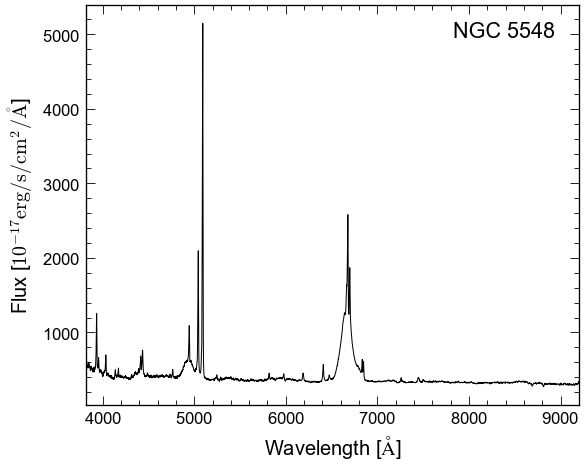

In [207]:
import matplotlib.pyplot as plt
import scienceplots
import numpy as np

#Getting Spectral Data
spectral_data = SDSS.get_spectra(plate = plate, mjd = mjd, fiberID = fiberID)
spectrum = spectral_data[0][1].data
print(spectrum.names)

#Defining Variables 
flux = np.array(spectrum['flux']) 
wavelength = 10 ** np.array(spectrum['loglam'])


#Ploting Spectrum
def plot_sdss_standard_style(wavelength, flux, plate, mjd, fiberID):
    plt.rcParams.update({
        "figure.figsize": (5, 4),
        "figure.dpi": 120,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica"],
        "axes.linewidth": 0.8,      
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.top": True,
        "ytick.right": True,
        "xtick.minor.visible": True, 
        "ytick.minor.visible": True
    })

    fig, ax = plt.subplots()

    ax.plot(wavelength, flux, color='black', lw=0.6)
    ax.text(0.95, 0.92, f"{target_object}", transform=ax.transAxes, ha='right', fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(which='major', length=5.5)
    ax.tick_params(which='minor', length=3)
    ax.set_xlabel(r'Wavelength [$\mathrm{\AA}$]', fontsize=12)
    ax.set_ylabel(r'Flux [$10^{-17} \mathrm{erg/s/cm^2/\mathring{A}}$]', fontsize=12)
    ax.set_xlim(wavelength.min(), wavelength.max())
    plt.tight_layout()
    return fig, ax

fig, ax = plot_sdss_standard_style(wavelength, flux, plate, mjd, fiberID)